In [1]:
# -*- coding: utf-8 -*-
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
from mpmath import mp
import scipy.io as scio

dtype = torch.float
device = torch.device("cuda:0")
device = torch.device("cpu")

weights = scio.loadmat("MATLABtest/volume_weights.mat")
pw1 = weights["pw1"]
pb1 = weights["pb1"]
pw2 = weights["pw2"]
pb2 = weights["pb2"]
np.shape(pb2)

(1, 1)

In [2]:
class Poly1(torch.nn.Module):
    def __init__(self,dimension):
        super().__init__()
        self.dim = dimension

    def forward(self, x):
        # return poly(1, self.dim)
        return -torch.log(1 - (-torch.exp(x)))

class Qnet(torch.nn.Module):
    def __init__(self, dimension):
        super().__init__()
        with torch.no_grad():
            self.model = torch.nn.Sequential(torch.nn.Linear(dimension+1, 2**dimension, bias=False, dtype=torch.float32, device=device), Poly1(dimension), torch.nn.Linear(2**dimension, 1, bias=False, dtype=torch.float32,device=device))

        tpp = []
        for i in np.arange(0, 2**dimension, 1):
            tpp.append(list(np.binary_repr(i, width=dimension)))
        
        tpp = np.array(tpp).astype(float)
        S = torch.tensor(np.concatenate(((tpp == 0) * -1 + tpp, np.full((2**dimension, 1), -1)), axis=1), dtype=torch.float32, device=device)
        w3 = (-torch.prod(S, axis=1).T).reshape(1,S.size(0))

        self.model[0].weight = torch.nn.Parameter(S)
        self.model[2].weight = torch.nn.Parameter(w3)

    def forward(self, x):
        return self.model(x)

class Intergrator():
    def __init__(self,dimension):
        if (dimension != 1):
            print("activation function only works for 1 dimesnions for now")
        self.dim = dimension
        self.qnet = Qnet(dimension)

    def apply(self, W1, B1, W2, B2):
        y = torch.cat((W1, B1.reshape(W1.size(0),1)), axis=1)
        res = torch.div(self.qnet(y), torch.prod(W1, axis = 1).reshape(W1.size(0),1)) + 2**self.dim
        self.model = torch.nn.Linear(W2.size(1),1, dtype=torch.float32,device=device)
        self.model.weight = torch.nn.Parameter(W2)
        self.model.bias = torch.nn.Parameter(B2*(2**self.dim))

        return self.model(res.T)


In [3]:
W1 = torch.tensor([[-53.099407, 1.5240264, -0.17084326,-1.380339, -0.72163534, -0.30636203, -0.7825347, 2.1130767, 2.3055365, 3.301027]], dtype=torch.float32, device=device)
W1 = W1.T
B1 = torch.tensor([26.595804, -1.7131307, 0.44687968, -0.87286687, -3.1546798, -2.0160902, -0.24203205, 0.514264, -0.19717565, 4.175638], dtype=torch.float32, device=device)

W2 = torch.tensor([[-0.30055588, 3.15199, 1.475628, -0.20895372, 0.3831912, 3.4266005, 0.19389513, -2.9015236, 1.8864253, -2.0440385]], dtype=torch.float32, device=device)
B2 = torch.tensor([[1.4603579]], dtype=torch.float32, device=device)

mp.simplify(mp.polylog(1,10))

AttributeError: 'MPContext' object has no attribute 'simplify'

In [4]:
for i in range(1000):
    W1 = torch.tensor([[-53.099407, 1.5240264, -0.17084326,-1.380339, -0.72163534, -0.30636203, -0.7825347, 2.1130767, 2.3055365, 3.301027]], dtype=torch.float32, device=device)
    W1 = W1.T
    B1 = torch.tensor([26.595804, -1.7131307, 0.44687968, -0.87286687, -3.1546798, -2.0160902, -0.24203205, 0.514264, -0.19717565, 4.175638], dtype=torch.float32, device=device)

    W2 = torch.tensor([[-0.30055588, 3.15199, 1.475628, -0.20895372, 0.3831912, 3.4266005, 0.19389513, -2.9015236, 1.8864253, -2.0440385]], dtype=torch.float32, device=device)
    B2 = torch.tensor([[1.4603579]], dtype=torch.float32, device=device)
    tests = Intergrator(1).apply(W1, B1, W2, B2)

print(tests)

tensor([[0.7539]], grad_fn=<AddmmBackward0>)


tensor([0.5003, 0.5003, 0.5003,  ..., 0.4999, 0.4999, 0.4999])
tensor([0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000])


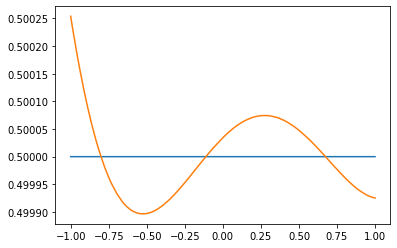

In [7]:
input_size = 1
hidden_size = 100
output_size = 1

# Create Tensors to hold input and outputs.
x = torch.linspace(-1, 1, 2000, device=device)
y = torch.sin(x)

f1 = lambda x: ((x < .5) * torch.pow(x, 2) + (x > .5) * x)   
f1 = lambda x: (x * 0) +0.5
y = f1(x)

# plt.plot(x,y)

# Prepare the input tensor (x, x^2, x^3).
xx = x.unsqueeze(-1)

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size, device=device),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size, output_size, device=device),
    torch.nn.Flatten(0, output_size)
)
loss_fn = torch.nn.MSELoss(reduction='sum')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use RMSprop; the optim package contains many other
# optimization algorithms. The first argument to the RMSprop constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer.zero_grad()
for t in range(2000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(xx)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    # if t % 100 == 99:
    #     print(t, loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

plt.plot(x.cpu().detach().numpy(), y.cpu().detach().numpy())
with torch.no_grad():
    print(model(xx))
    plt.plot(x.cpu().detach().numpy(), model(xx).cpu().detach().numpy())
print(y)

In [13]:
temp = Intergrator(1).apply(model[0].weight, model[0].bias, model[2].weight, model[2].bias)

print(model[0].weight.size())
print(model[0].bias.size())
print(model[2].weight.size())
print(model[2].bias.size())

print(temp)

torch.Size([100, 1])
tensor([[1.0000]], grad_fn=<AddmmBackward0>)
